# ${}^{4}{\rm He}$

The interaction is defined in `helium4.py`. It is nonlocal, and so is the counterterm. We will use it to tune the scattering length, $a_0$, **and** the effective range, $r_0$, over a range of short-distance cutoffs, $R$.

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import helium4 as he4

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
import mu2

In [3]:
MOMENTA = np.linspace(0.01/he4.BETA6, 0.3/he4.BETA6, 30)
X = he4.FACTOR * he4.BETA6 # K•Å^3
KCD = -1/he4.A0 + he4.R0/2*MOMENTA**2

In [4]:
# First, we will tune k(cot(delta)). Then we'll go back and refine a_0 and r_0.
def kcd_diff(gpair, sys):
    kcd = sys.kcotd_gen_fast(MOMENTA, *gpair)
    return np.sum(((KCD - kcd)/(1e-4*np.ones(KCD.size)))**2)


def inverse_a0_diff(gi, gj, sys):
    a0, _ = sys.a0_and_r0(gi, gj, MOMENTA, use_c=True)
    return (1/he4.A0 - 1/a0)*he4.A0

In [5]:
ELL = 0
lo_rg_flow = np.loadtxt('datfiles/he4_LO_nonlocal_rg_flow.txt')

In [95]:
index = 4
s = he4.Helium4System(lo_rg_flow[index, 0], ELL)

In [96]:
g_nlo_test = np.linspace(-60, -80, 30)*X
test_results = []
guess = lo_rg_flow[index, 1]
g_lo_test = np.array([])

for gj in g_nlo_test:
    result = optimize.fsolve(inverse_a0_diff, guess, args=(gj, s))
    test_results.append(s.a0_and_r0(result[0], gj, MOMENTA, p0=[he4.A0, he4.R0, 1], use_c=True))
    guess = result[0]
    g_lo_test = np.append(g_lo_test, guess)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [97]:
test_results = np.array(test_results)

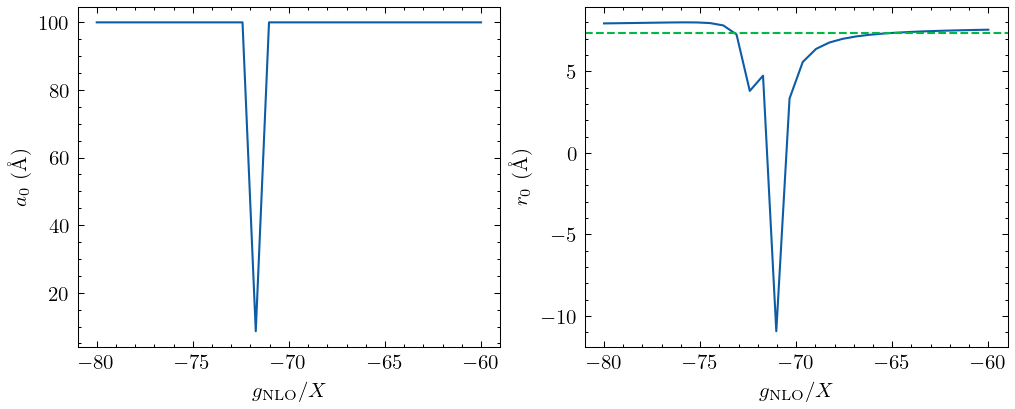

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(2*gr*h, h), dpi=150)
fig.patch.set_facecolor('white')

ax[0].plot(g_nlo_test/X, test_results[:, 0])
ax[1].plot(g_nlo_test/X, test_results[:, 1])

ax[1].axhline(he4.R0, linestyle='--', color='C1')
ax[0].set_xlabel(r'$g_{\rm NLO}/X$')
ax[0].set_ylabel(r'$a_0$ (Å)')

ax[1].set_xlabel(r'$g_{\rm NLO}/X$')
ax[1].set_ylabel(r'$r_0$ (Å)');

In [99]:
jj = np.argmin(np.abs(test_results[:, 1] - he4.R0))
test = np.array([g_lo_test[jj], g_nlo_test[jj]])

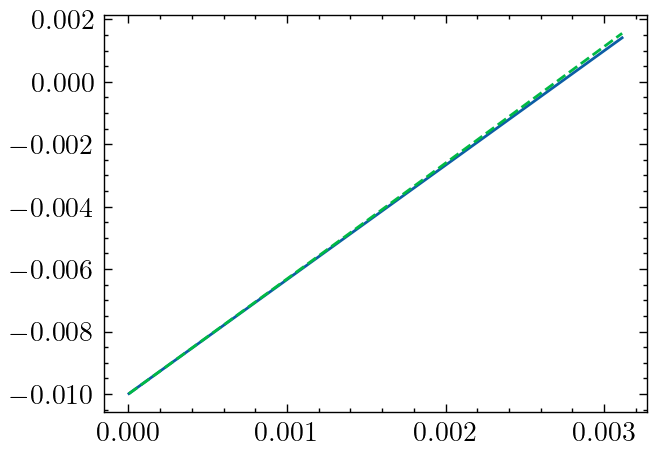

In [100]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(MOMENTA**2, KCD)
ax.plot(MOMENTA**2, s.effective_range_expansion(*test, MOMENTA, use_c=True), linestyle='--');

In [101]:
def rel_diff(obs, exp):
    return (obs - exp) / exp
    
def a0_r0_diff(theta, s):
    gi, gj = theta
    a0, r0 = s.a0_and_r0(gi, gj, MOMENTA, use_c=True)
    return np.array([rel_diff(a0, he4.A0), rel_diff(r0, he4.R0)])

In [102]:
result = optimize.fsolve(a0_r0_diff, test, args=(s))

In [103]:
s.a0_and_r0(*result, MOMENTA, use_c=True)

(100.00000184476608, 7.329999990689496)

In [104]:
lo_rg_flow[index, 0], *test

(2.1596091960616217, 69015.46702866585, -4269.444193544175)

In [105]:
he4.C6

10130.537638625547

In [ ]:
Ri = lo_rg_flow[start, 0]
guess = np.array([0.84*lo_rg_flow[1, 1], -500])
results = []

while he4.BETA6/Ri <= 8:
    s = he4.Helium4System(Ri, ELL)
    result = optimize.minimize(
        kcd_diff,
        guess,
        args=(s),
        bounds=((-1e5*X, 1e5*X), (-100*X, 100*X))
    )
    bss = s.bound_state_spectrum(*result.x)
    
    g_lo, g_nlo = result.x
    b_2 = bss[0]
    a_0, r_0 = s.a0_and_r0(g_lo, g_nlo, MOMENTA, use_c=True)
    
    results.append([Ri, g_lo, g_nlo, b_2])
    
    print(f'R = {Ri:.2f}  β_6/R = {he4.BETA6/Ri:.4f}  g_LO = {g_lo:.2e}  g_NLO = {g_nlo:.2e}  a_0 = {a_0:.2e}  \
r_0 = {r_0:.2e}  B_2 = {b_2:.4e}')
    
    Ri *= 0.99
    if len(results) < 5:
        guess = result.x
    else:
        z = np.array(results)
        lo_curve = interp1d(z[:, 0], z[:, 1], kind='cubic', fill_value='extrapolate')
        nlo_curve = interp1d(z[:, 0], z[:, 2], kind='cubic', fill_value='extrapolate')
        guess = np.array([lo_curve(Ri), nlo_curve(Ri)])

In [10]:
s = he4.Helium4System(lo_rg_flow[1, 0], ELL)

In [11]:
result = optimize.differential_evolution(kcd_diff, ((-1e5*X, 1e5*X), (-100*X, 100*X)), args=(s))

RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

In [74]:
s.a0_and_r0(*result.x, momenta, use_c=True)

(98.91044215874547, 7.310410426330167)

In [57]:
s.a0_and_r0(*result.x, momenta, use_c=True)

(99.99499786179156, 8.399732882631257)

In [32]:
ii = np.argmin(np.abs(he4.R0 - test_results[:, 1]))

In [33]:
g_lo_test[ii]/X, g_nlo_test[ii]/X

(555.3141270359554, -41.05263157894737)

In [34]:
result = optimize.fsolve(a0_r0_diff, [g_lo_test[ii], g_nlo_test[ii]], args=(s))

In [35]:
result

array([36184.79646774, -2673.25771318])

In [15]:
s.a0_and_r0(result[0], result[1], momenta, use_c=True)

(99.999999018398, 7.3300000026052725)

In [17]:
guess = result

In [18]:
from scipy.interpolate import interp1d

In [20]:
s.bound_state_spectrum(*result)

array([-0.00131109])

In [24]:
for i in range(nR):
    Ri = Rs[i]
    s = he4.construct_helium4_system(Ri, ELL)
    result = optimize.fsolve(a0_r0_diff, guess, args=(s))
    
    a0, r0 = s.a0_and_r0(*result, momenta, use_c=True)
    bss = s.bound_state_spectrum(*result)
    
    g_los[i] = result[0]
    g_nlos[i] = result[1]
    b2s[i] = bss[0]
    
    guess = result
    
    print(f'i = {i}  R = {Ri:.4f}  a_0 = {a0:.2f}  r_0 = {r0:.2f}  g_LO = {result[0]:.4e}\
  g_NLO = {result[1]:.4e}  B_2 = {bss[0]:.4e}')

i = 0  R = 2.6885  a_0 = 100.00  r_0 = 7.33  g_LO = 3.6185e+04  g_NLO = -2.6733e+03  B_2 = -1.3111e-03


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


i = 1  R = 2.5334  a_0 = 2.72  r_0 = 7.22  g_LO = -2.3511e+04  g_NLO = 7.4659e+03  B_2 = -6.3050e+03
i = 2  R = 2.3952  a_0 = 4.34  r_0 = 4.20  g_LO = 1.0108e+07  g_NLO = -6.1038e+05  B_2 = -8.2269e+01
i = 3  R = 2.2713  a_0 = 3.96  r_0 = 4.35  g_LO = 5.6370e+09  g_NLO = -4.6486e+07  B_2 = -1.0158e+03
i = 4  R = 2.1596  a_0 = 3.68  r_0 = 4.57  g_LO = -2.4559e+10  g_NLO = 1.6296e+09  B_2 = -3.9383e+09


KeyboardInterrupt: 

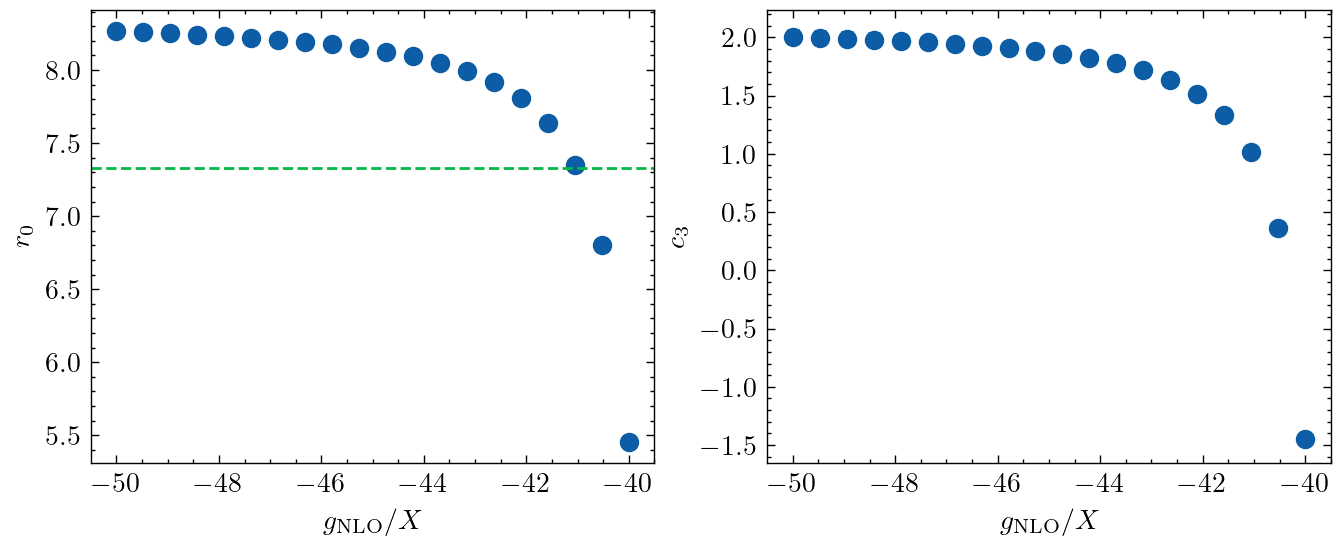

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(2*gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for (gi, gj) in zip(g_lo_test, g_nlo_test):
    (c0, c2, c3), (dc0, dc2, dc3) = s.effective_range_parameters(gi, gj, momenta,
                                           lambda x, c0, c2, c3: c0 + c2*x**2 + c3*x**3,
                                           p0=[100, 1, 1], use_c=True)
    ax[0].errorbar(gj/X, 2*c2, yerr=2*dc2, color='C0', capsize=2)
    ax[0].scatter(gj/X, 2*c2, color='C0', marker='o')
    
    ax[1].errorbar(gj/X, c3, yerr=dc3, color='C0', capsize=2)
    ax[1].scatter(gj/X, c3, color='C0', marker='o')

ax[0].axhline(he4.R0, color='C1', linestyle='--')
ax[0].set_xlabel(r'$g_{\rm NLO}/X$')
ax[0].set_ylabel(r'$r_0$');

ax[1].set_xlabel(r'$g_{\rm NLO}/X$')
ax[1].set_ylabel(r'$c_3$');

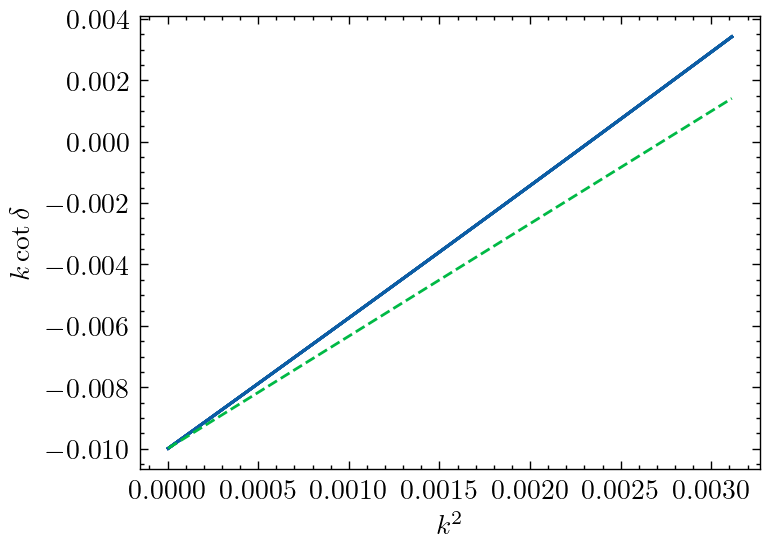

In [36]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for (gi, gj) in zip(g_lo_test, g_nlo_test):
    ax.plot(momenta**2, s.kcotd_gen_fast(momenta, gi, gj), color='C0', alpha=0.5)

ax.plot(momenta**2, KCD, color='C1', linestyle='--')
ax.set_xlabel(r'$k^2$');
ax.set_ylabel(r'$k\cot\delta$');

In [9]:
for i in range(nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.minimize(kcd_diff, guess, args=(s))
    gs = result.x
    a0, r0 = s.a0_and_r0(*gs, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-2 and np.abs((he4.R0 - r0)/he4.R0) < 1e-2:
        e2s = s.bound_state_spectrum(*gs)
        g_los[i] = gs[0]
        g_nlos[i] = gs[1]
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
        guess = gs
    else:
        break

TypeError: System.kcotd_gen_fast() missing 1 required positional argument: 'gnlo'

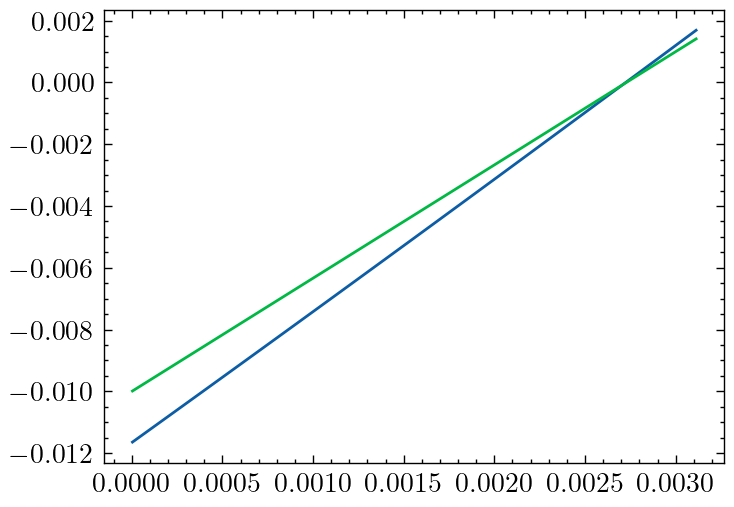

In [12]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(momenta**2, s.kcotd_gen_fast(momenta, *gs))
ax.plot(momenta**2, KCD);

In [7]:
restart = 2
s = he4.construct_helium4_system(Rs[restart], ELL)

In [8]:
guess = -2200*X
inverse_a0_diff(guess, s)

0.011628295276288475

In [9]:
for i in range(restart, nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.fsolve(inverse_a0_diff, guess, args=(s), factor=0.1)
    g = result[0]
    a0, r0 = s.a0_and_r0(g, 0, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-4:
        e2s = s.bound_state_spectrum(g, 0)
        gs[i] = g
        r0s[i] = r0
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
    else:
        break

i = 2  R = 2.3952029265410713  g = -2.1799e+03 X  a0 = 1.0000e+02  r0 = 7.9727e+00  b2 = 0.0013214408847803851
i = 3  R = 2.2713131199958436  g = 1.3034e+02 X  a0 = 1.0000e+02  r0 = 7.8292e+00  b2 = 0.0013191038331283743
i = 4  R = 2.1596091960616217  g = 4.8941e+02 X  a0 = 1.0000e+02  r0 = 7.7232e+00  b2 = 0.0013173873169407763
i = 5  R = 2.0583775149962333  g = 7.1346e+02 X  a0 = 1.0000e+02  r0 = 7.6482e+00  b2 = 0.0013161765744706488
i = 6  R = 1.9662113576083418  g = 9.0763e+02 X  a0 = 1.0000e+02  r0 = 7.5979e+00  b2 = 0.0013153667611003478
i = 7  R = 1.8819451565679846  g = 1.0975e+03 X  a0 = 1.0000e+02  r0 = 7.5666e+00  b2 = 0.0013148625513397642
i = 8  R = 1.8046049446542318  g = 1.2927e+03 X  a0 = 1.0000e+02  r0 = 7.5490e+00  b2 = 0.0013145783506912495
i = 9  R = 1.7333705389441965  g = 1.4981e+03 X  a0 = 1.0000e+02  r0 = 7.5403e+00  b2 = 0.0013144388604214492
i = 10  R = 1.6675463412627713  g = 1.7169e+03 X  a0 = 1.0000e+02  r0 = 7.5367e+00  b2 = 0.0013143801973354624
i = 11  

In [10]:
restart = 20
s = he4.construct_helium4_system(Rs[restart], ELL)

In [25]:
guess = 5200*X
inverse_a0_diff(guess, s)

0.01756929408829582

In [27]:
for i in range(restart, nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.fsolve(inverse_a0_diff, guess, args=(s), factor=0.1)
    g = result[0]
    a0, r0 = s.a0_and_r0(g, 0, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-4:
        e2s = s.bound_state_spectrum(g, 0)
        gs[i] = g
        r0s[i] = r0
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
        guess = g
    else:
        break

i = 20  R = 1.2085886326583386  g = 5.2006e+03 X  a0 = 1.0000e+02  r0 = 7.3942e+00  b2 = 0.0013121079582042146
i = 21  R = 1.1762157228549903  g = 5.8092e+03 X  a0 = 1.0000e+02  r0 = 7.3681e+00  b2 = 0.0013116937950748658
i = 22  R = 1.1455318344326864  g = 6.5581e+03 X  a0 = 1.0000e+02  r0 = 7.3427e+00  b2 = 0.0013112929731866894
i = 23  R = 1.1164081437267706  g = 7.5732e+03 X  a0 = 1.0000e+02  r0 = 7.3189e+00  b2 = 0.001310916807813701
i = 24  R = 1.0887286029732142  g = 9.2501e+03 X  a0 = 1.0000e+02  r0 = 7.2972e+00  b2 = 0.00131057412079892
i = 25  R = 1.0623883948367656  g = 1.3829e+04 X  a0 = 1.0000e+02  r0 = 7.2780e+00  b2 = 0.0013102710635809318


In [28]:
restart = 26
s = he4.construct_helium4_system(Rs[restart], ELL)

In [38]:
guess = -40000*X
inverse_a0_diff(guess, s)

0.014427023535276869

In [39]:
for i in range(restart, nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.fsolve(inverse_a0_diff, guess, args=(s), factor=0.1)
    g = result[0]
    a0, r0 = s.a0_and_r0(g, 0, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-4:
        e2s = s.bound_state_spectrum(g, 0)
        gs[i] = g
        r0s[i] = r0
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
        guess = g
    else:
        break

i = 26  R = 1.0372926059823537  g = -3.8923e+04 X  a0 = 1.0000e+02  r0 = 7.2615e+00  b2 = 0.0013100111334430663
i = 27  R = 1.0133550843058379  g = 1.4832e+03 X  a0 = 1.0000e+02  r0 = 7.2478e+00  b2 = 0.0013097954390147329
i = 28  R = 0.9904974508252551  g = 4.6927e+03 X  a0 = 1.0000e+02  r0 = 7.2369e+00  b2 = 0.0013096229901129013
i = 29  R = 0.9686482423511685  g = 6.2308e+03 X  a0 = 1.0000e+02  r0 = 7.2285e+00  b2 = 0.001309491010550352
i = 30  R = 0.9477421651781218  g = 7.3277e+03 X  a0 = 1.0000e+02  r0 = 7.2224e+00  b2 = 0.001309395414593954
i = 31  R = 0.9277194433785839  g = 8.2575e+03 X  a0 = 1.0000e+02  r0 = 7.2183e+00  b2 = 0.0013093311560888024
i = 32  R = 0.9085252479983373  g = 9.1166e+03 X  a0 = 1.0000e+02  r0 = 7.2159e+00  b2 = 0.0013092925929792864
i = 33  R = 0.8901091956740469  g = 9.9480e+03 X  a0 = 1.0000e+02  r0 = 7.2147e+00  b2 = 0.001309273863222863
i = 34  R = 0.872424907018271  g = 1.0774e+04 X  a0 = 1.0000e+02  r0 = 7.2144e+00  b2 = 0.0013092691650489956
i = 

In [40]:
import matplotlib.pyplot as plt

plt.style.use('science')
gr = 4/3
h = 3

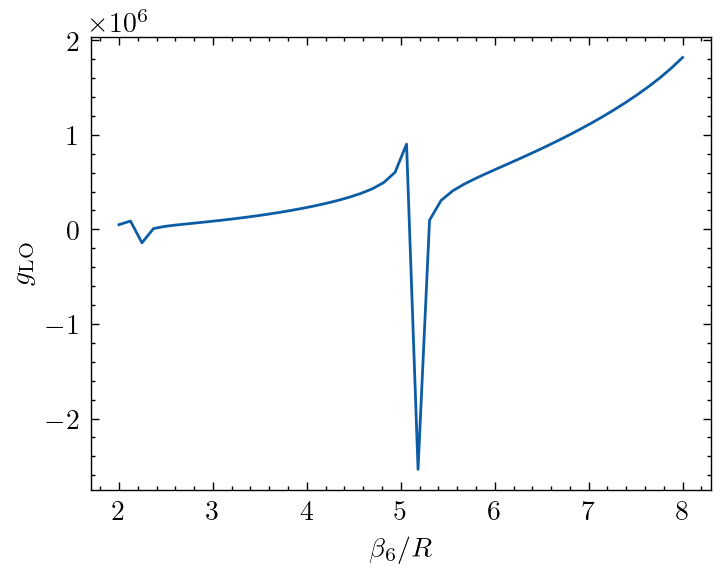

In [51]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(he4.BETA6/Rs, gs)

ax.set_xlabel(r'$\beta_6/R$')
ax.set_ylabel(r'$g_{\rm LO}$');

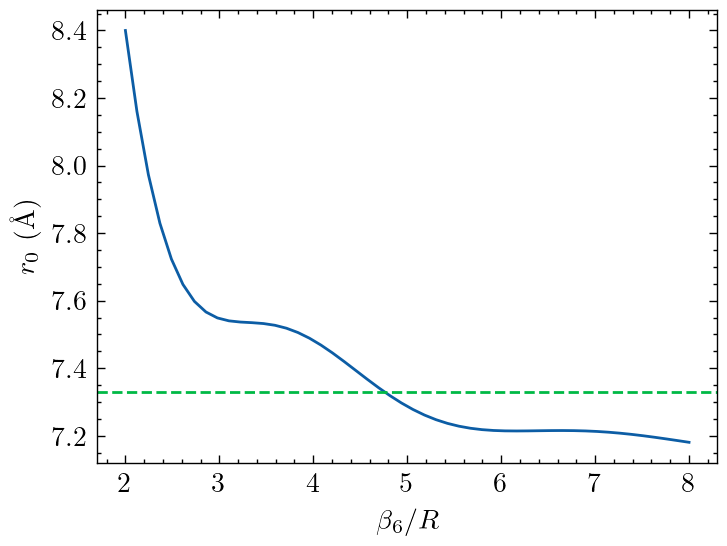

In [52]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(he4.BETA6/Rs, r0s)
ax.axhline(he4.R0, color='C1', linestyle='--')

ax.set_xlabel(r'$\beta_6/R$')
ax.set_ylabel(r'$r_0$ (Å)');

In [53]:
np.savetxt('datfiles/he4_LO_nonlocal_rg_flow.txt', np.vstack((Rs, gs)).T, header='R (Å)  g ()')

In [54]:
np.savetxt('datfiles/he4_LO_nonloca_r0s.txt', np.vstack((Rs, r0s)).T, header='R (Å)  r_0 (Å)')